# PAMM Clustering - Individual Datasets

Sample Notebook to use PAMM clustering algorithm (orignal [paper](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.7b00993)) with the GMPLabTools implementation.

The keyword **INDIVIDUAL** datasets refers to the tratments of datasets towards the kernel density estimation (KDE), which is done for each individual set.

In [1]:
import time
import warnings
import random
import seaborn as sns
import numpy as np

from scipy.cluster.hierarchy import dendrogram

from gmplabtools.analysis import DataSampler
from gmplabtools.pamm import PammGMM
from gmplabtools.pamm import Pamm
from gmplabtools.analysis import calculate_adjacency, adjancency_dendrogram
from gmplabtools.analysis import ClusterRates

import matplotlib.pyplot as plt
%matplotlib inline

## Utilities Functions

In [2]:
def make_colors(clust,mode='tab20'):
    if np.min(clust) == -1:
        N = np.unique(clust).shape[0] - 1
        colors = sns.color_palette(mode, N) + [(0,0,0)]
    else:
        N = np.unique(clust).max()
        colors = sns.color_palette(mode, N)
        
    return colors


def get_axes(L, max_col=3, fig_frame=(5,4), res=100):
    cols = L if L <= max_col else max_col
    rows = int(L / max_col) + int(L % max_col != 0)
    fig, ax = plt.subplots(rows, cols, figsize=(cols * fig_frame[0], rows * fig_frame[1]), dpi=res)
    ax =  ax.flatten()
    return fig, ax


def shuffle(X, Y=None, n=None):
    l = np.arange(X.shape[0])
    random.shuffle(l)
    if Y is None:
        return X[l[:n],:]
    elif Y is None and n is None:
        return X[l,:]
    elif n is None:
        return X[l,:], Y[l]
    else: 
        return X[l[:n],:], Y[l[:n]]
    


The data that one wants to process needs to be load and initialized as follows

`SYSX1 = np.loadtxt(my_dir/my_fileX1)`

and then put in a well named dictionary

`SYST = {
    'name_X1' : SYSX1,
    'name_X2' : SYSX2,
        ...   : ...  ,
}`

In [3]:
PCA_DIR='/home/andreag/SOFTSYSTEMS/FIBERSminimal_10mu/pca_files/rcut8'

In [4]:
SYS1 = np.loadtxt(PCA_DIR+'/PCA_fiber1_c1_10mu_ev10ns_rcut8_trj0-1001-1_INDIVIDUAL.pca')
SYS2 = np.loadtxt(PCA_DIR+'/PCA_fiber2_c5_10mu_ev10ns_rcut8_trj0-1001-1_INDIVIDUAL.pca')
SYS3 = np.loadtxt(PCA_DIR+'/PCA_fiber3_n0_10mu_ev10ns_rcut8_trj0-1001-1_INDIVIDUAL.pca')

In [5]:
SYST = {
    'fib1' : SYS1,
    'fib2' : SYS2,
    'fib3' : SYS3,
}

In [6]:
DIMS = []
for sys in SYST:
    print(f"System {sys} dimension: {SYST[sys].shape[1]}")
    DIMS.append(SYST[sys].shape[1])
if len(np.unique(DIMS)) == 1:
    DIM = np.unique(DIMS)[0]
    print(f"All the systems have the same dimensionality: {DIM}")
else:
    print(f"Systems have different dimensionality\n{DIMS}!!")

System fib1 dimension: 3
System fib2 dimension: 3
System fib3 dimension: 3
All the systems have the same dimensionality: 3


## General variables

In [7]:
CHUNK = 5000
LABEL_SIZE = 18
L = len(SYST)
SAVE_PLOT = False

## Algorithm inputs

The paramters for the calculation needs to be stored as follows.

The meaning of these parameters can be found in the orignal [paper](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.7b00993).

The `nm_frame` refers to how many components a frame of the trajectory is composed (es. fiber having 40 monomers `nm_frame : 40`).

In [8]:
default_inputs = dict(
    # cluster
    distance = "minkowski",
    size = 1000,
    p = 2,
    generate_grid = True,
    savegrid = "grid_data",
    # cluster inputs
    d = DIM,
    fspread = 0.3,
    ngrid = 1000,
    qs = 1,
    o = "pamm",
    trajectory = None,
    merger = 0.005,
    bootstrap = 73
)

Definition of the exeptions for the individual datasets; the new variables stored here will overide the ones present in the `default_inputs`.

For example:

`datasets_cluster = [
    (SYSX1, {'o' : 'pamm_SYSX1', 'savegrid' : "grid_SYSX1", 
             'readgrid' : "grid_SYSX1", 
             'trajectory' : my_dir/my_data'}),
    (SYSX2, {'size' : newNsize, 'ngrid' : newNsize,
             'o' : 'pamm_SYSX2', 'savegrid' : "grid_SYSX2", 
             'readgrid' : "grid_SYSX2", 
             'trajectory' : my_dir/my_data'})
]`

The fundamental part is the definition of the outputs files and the different trajs.

In [9]:
datasets_cluster = [
    (SYS1, {'o' : 'pamm_fib1', 'savegrid' : "grid_fib1", 
               'trajectory' : PCA_DIR+'/PCA_fiber1_c1_10mu_ev10ns_rcut8_trj0-1001-1_INDIVIDUAL.pca'}),
    (SYS2, {'size' : 2000, 'ngrid' : 2000,
            'o' : 'pamm_fib2', 'savegrid' : "grid_fib2", 
            'trajectory' : PCA_DIR+'/PCA_fiber2_c5_10mu_ev10ns_rcut8_trj0-1001-1_INDIVIDUAL.pca'}),
    (SYS3, {'size' : 2000, 'ngrid' : 2000,
            'o' : 'pamm_fib3', 'savegrid' : "grid_fib3", 
            'trajectory' : PCA_DIR+'/PCA_fiber3_n0_10mu_ev10ns_rcut8_trj0-1001-1_INDIVIDUAL.pca'})
]

datasets_predict = [
    (SYS1, {'sys' : 'fib1', 'nm_frame' : 40}),
    (SYS2, {'sys' : 'fib2', 'nm_frame' : 40}),
    (SYS3, {'sys' : 'fib3', 'nm_frame' : 40}),
]

## Original dataset plot

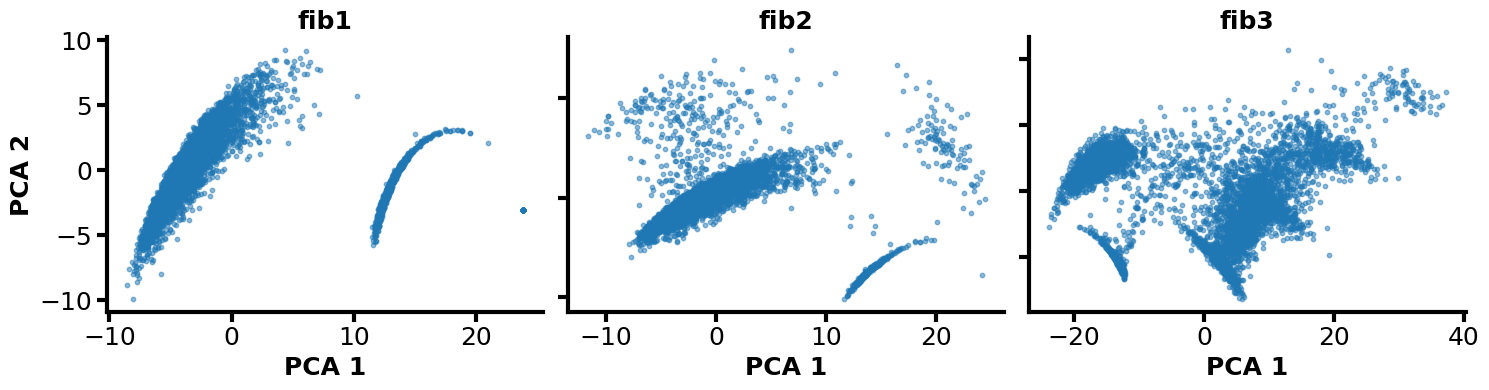

In [10]:
colors=sns.color_palette('tab10', L)
fig, ax = get_axes(L, max_col=L)
for i,s in enumerate(SYST):
    ax[i].scatter(SYST[s][:CHUNK,0], SYST[s][:CHUNK,1], s=10, linewidth=1, marker="o", alpha=0.5)
    ax[i].set_title(f"{s}", weight='bold',size=LABEL_SIZE)
    ax[i].tick_params(labelsize=LABEL_SIZE,width=3,size=7)
    
    for side in ['bottom','right','top','left']:
        ax[i].spines[side].set_linewidth(3)
    
    if i == 0:
        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
        ax[i].set_ylabel('PCA 2', weight='bold',size=LABEL_SIZE)
        for side in ['right','top']:
            ax[i].spines[side].set_visible(False)          
    else:
        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
        ax[i].tick_params(labelleft=None)
        for side in ['right','top']:
            ax[i].spines[side].set_visible(False)

fig.tight_layout()

if SAVE_PLOT:
    plt.savefig("data_set_soap_pca.png")

## PAMM - Clustering part

In [11]:
for i_dataset, (dataset, algo_params) in enumerate(datasets_cluster):
    # update parameters with dataset-specific values
    params = default_inputs.copy()
    params.update(algo_params)

    # Clustering
    p = Pamm(params)
    print('\n#-----------------------------------------------')
    print(p.command_parser)
    
    print('\nRUNNING Clustering')
    t0 = time.time()
    p.run()
    t1 = time.time()
    print('TIME= '+str(np.round(t1-t0, 2))+' s \n')


#-----------------------------------------------
/home/andreag/github_gmplabtools/gmplabtools/gmplabtools/pamm/bin/pamm -d 3 -bootstrap 73 -fspread 0.3 -qs 1 -o pamm_fib1 -ngrid 1000 -merger 0.005 -v < /home/andreag/SOFTSYSTEMS/FIBERSminimal_10mu/pca_files/rcut8/PCA_fiber1_c1_10mu_ev10ns_rcut8_trj0-1001-1_INDIVIDUAL.pca

RUNNING Clustering
Executing command: /home/andreag/github_gmplabtools/gmplabtools/gmplabtools/pamm/bin/pamm -d 3 -bootstrap 73 -fspread 0.3 -qs 1 -o pamm_fib1 -ngrid 1000 -merger 0.005 -v < /home/andreag/SOFTSYSTEMS/FIBERSminimal_10mu/pca_files/rcut8/PCA_fiber1_c1_10mu_ev10ns_rcut8_trj0-1001-1_INDIVIDUAL.pca
TIME= 17.05 s 


#-----------------------------------------------
/home/andreag/github_gmplabtools/gmplabtools/gmplabtools/pamm/bin/pamm -d 3 -bootstrap 73 -fspread 0.3 -qs 1 -o pamm_fib2 -ngrid 2000 -merger 0.005 -v < /home/andreag/SOFTSYSTEMS/FIBERSminimal_10mu/pca_files/rcut8/PCA_fiber2_c5_10mu_ev10ns_rcut8_trj0-1001-1_INDIVIDUAL.pca

RUNNING Clustering
Execut

## PAMM - Prediction on data part

In [12]:
def get_gmm(SYST):
    return PammGMM.read_clusters('pamm_'+SYST+'.pamm', 
                                   grid_file='pamm_'+SYST+'.grid', 
                                   bootstrap_file='pamm_'+SYST+'.bs')

In [13]:
cluster_output = {}
num_clusters = {}
grid_cluster = {}
prob_output = {}
bootstr_output = {}
systnames = []
for i_dataset,dataset in enumerate(datasets_predict):
    run_syst = str(datasets_predict[i_dataset][1]['sys'])
    
    gmm = get_gmm(run_syst)
    num_clusters[run_syst] = np.unique(gmm.pk).shape[0]
    print(f"\nFor system {run_syst} there are {num_clusters[run_syst]} clusters")
    
    # Predict
    print('\nRUNNING Predict '+run_syst)
    t0 = time.time()
    
    x = datasets_predict[i_dataset][0]
    x_ = gmm.predict_proba(x)
    labels = np.argmax(x_, axis=1) #.reshape((-1, 1))

    t1 = time.time()
    print('TIME= '+str(np.round(t1-t0, 2))+' s \n')

    # Storing data
    cluster_output[run_syst] = labels
    grid_cluster[run_syst] = gmm.cluster
    prob_output[run_syst] = gmm.p
    bootstr_output[run_syst] = gmm.bs
    systnames.append(run_syst)

    # output for initial clustering
    np.savetxt(run_syst + "_clusters.dat", labels.reshape((-1, 1)))
    
    rates = ClusterRates(datasets_predict[i_dataset][1]['nm_frame'], 'label').calculate_matrix(labels.reshape((-1, 1)))
    np.savetxt(run_syst + "_rates.dat", rates)


For system fib1 there are 3 clusters

RUNNING Predict fib1
TIME= 2.5 s 


For system fib2 there are 5 clusters

RUNNING Predict fib2
TIME= 3.9 s 


For system fib3 there are 6 clusters

RUNNING Predict fib3
TIME= 4.58 s 



## Output post-processing

In [14]:
def PLTmatrixrates(ax,data,s=18):
    labels = ['0','1', '2', '3', '4', '5', '6','7','8']
    sns.heatmap(data, annot=True, fmt=".2f", cbar=False, ax=ax, annot_kws={"fontsize":s})
    ax.xaxis.tick_top()
    ax.set_xticklabels(labels, size='18', weight='bold')
    ax.set_yticklabels(labels, size='18', weight='bold')
    return ax

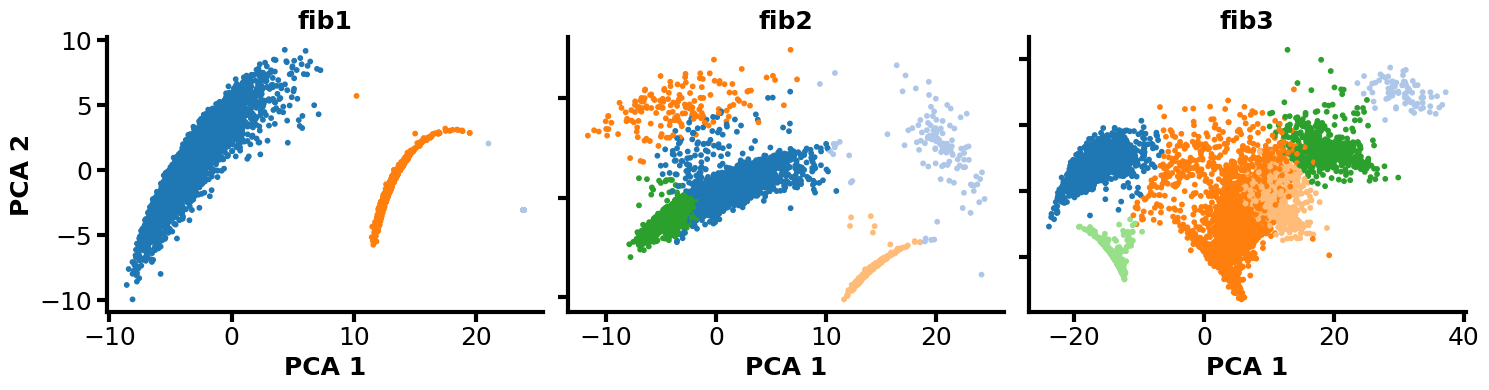

In [15]:
fig, ax = get_axes(L, max_col=L)
for i,sys in enumerate(systnames):
    colors=make_colors(num_clusters[sys],mode='tab20')
    labels = cluster_output[sys]
    ax[i].scatter(datasets_predict[i][0][:CHUNK,0], datasets_predict[i][0][:CHUNK,1], c=np.array(colors)[labels[:CHUNK]], s=10)
    ax[i].set_title(f"{sys}", weight='bold',size=LABEL_SIZE)
    ax[i].tick_params(labelsize=LABEL_SIZE,width=3,size=7)
    
    for side in ['bottom','right','top','left']:
        ax[i].spines[side].set_linewidth(3)
    
    if i == 0:
        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
        ax[i].set_ylabel('PCA 2', weight='bold',size=LABEL_SIZE)
        for side in ['right','top']:
            ax[i].spines[side].set_visible(False)          
    else:
        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
        ax[i].tick_params(labelleft=None)
        for side in ['right','top']:
            ax[i].spines[side].set_visible(False)

fig.tight_layout()

if SAVE_PLOT:
    fig.savefig('clusters_pamm.png')

### Cluster iterconversion matrices

These matrices $N_{clusters} \times N_{clusters}$ represent all the transfomation that clusters undergo during the trajectories analyzed.
A sample row $n_i$ gives you the probability, in terms of frequency, of that cluster to becomes the $n_j$ column cluster.

In [17]:
SYS1rates = np.loadtxt("./fib1_rates.dat")
SYS2rates = np.loadtxt("./fib2_rates.dat")
SYS3rates = np.loadtxt("./fib3_rates.dat")

RATES = {
    'fib1' : SYS1rates,
    'fib2' : SYS2rates,
    'fib3' : SYS3rates,
}

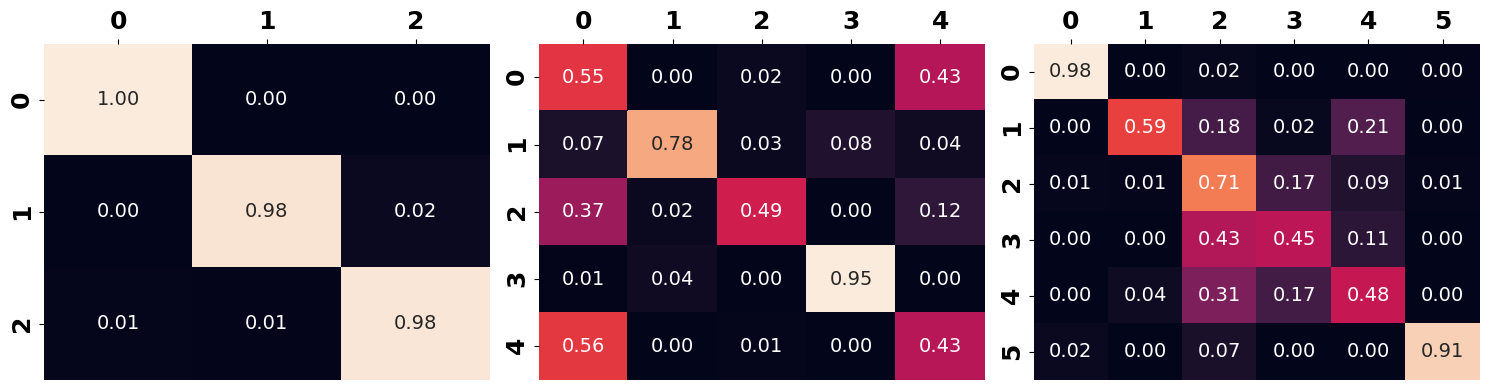

In [18]:
fig, ax = get_axes(L, max_col=3, fig_frame=(5,4), res=100)
for i,sys in enumerate(RATES):
    PLTmatrixrates(ax[i], RATES[sys], s=14)
    
fig.tight_layout()

if SAVE_PLOT:
    fig.savefig('micro_clusters_pamm_matrix.png')

### Clusters hierarchy

In [16]:
prob_output.keys()

dict_keys(['fib1', 'fib2', 'fib3'])

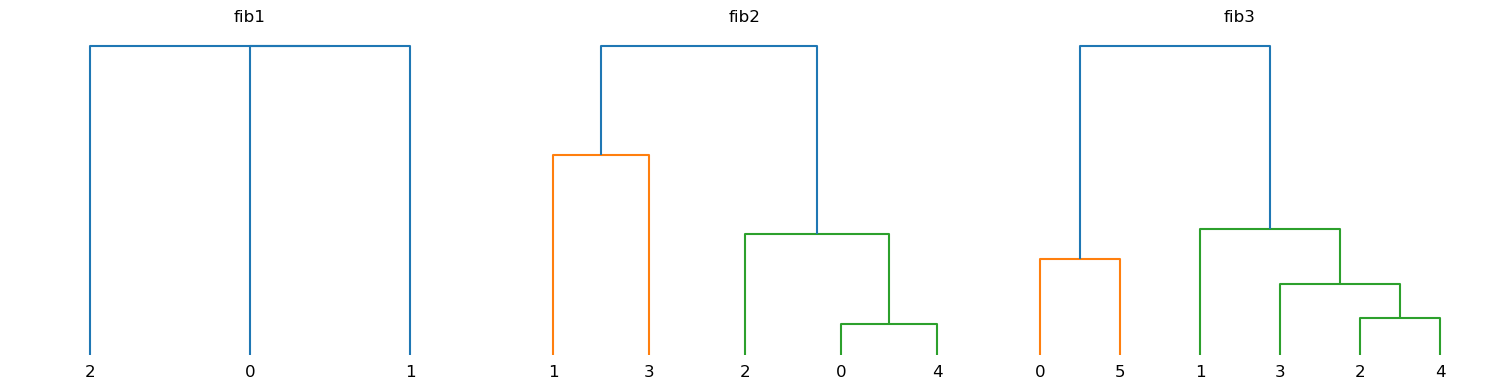

In [19]:
fig, ax = get_axes(L, max_col=L)
for i,den in enumerate(SYST):
    adjacency, mapping = calculate_adjacency(
    prob=prob_output[den],
    clusters=grid_cluster[den],
    bootstrap=bootstr_output[den]
    )

    z = adjancency_dendrogram(adjacency)
    _ = dendrogram(z, ax=ax[i], count_sort=True)['leaves']
    
    ax[i].set_title(den)
    ax[i].set_yticks([])
    ax[i].yaxis.set_ticks_position('none')
    
    for side in ['bottom','right','top','left']:
        ax[i].spines[side].set_visible(False)

fig.tight_layout()    
    
if SAVE_PLOT:
    fig.savefig('clusters_pamm_dendrogram.png')

### Clusters mearging (Macroclusters processing)

Macrocluster syntax definitino:

`mapping = [
    ('SYSX1', {MacroCl1: [microClx,...], 
               MacroCl2: [microCly,...]})
]`

where the mearging comes from the dendrogram.

In [23]:
mapping = [
    ('fib1', {0: [0],
              1: [2],
              2: [1]}),
    ('fib2', {0: [0,2,4],
              1: [3],
              2: [1]}),
    ('fib3', {0: [1,2,3,4],
              1: [5],
              2: [0]})
]

In [24]:
# it does not matter if one put np.argmax(y__, axis=1).reshape((-1,1)) \w or \wout the reshape part
macro_cluster_output = {}
rates_macro_clusters = {}

for s,macro_cl in enumerate(SYST):
    # Macro Cluster
    run_syst = macro_cl
    print("MACRO CLUSTERS - "+run_syst)
    
    y = datasets_predict[s][0]
    gmm = get_gmm(run_syst)
    y_ = gmm.predict_proba(y)
    y__ = np.zeros((y.shape[0], len(mapping[s][1])))
    for k, v in mapping[s][1].items():
        y__[:, k] = y_[:,v].sum(1)

    macro_cluster_output[macro_cl] = np.argmax(y__, axis=1)
    np.savetxt(run_syst+'_macro_cluster.dat', np.argmax(y__, axis=1).reshape((-1,1)) )
    
    rates = ClusterRates(datasets_predict[s][1]['nm_frame'], 'label').calculate_matrix(np.argmax(y__, axis=1).reshape((-1,1)) )
    rates_macro_clusters[macro_cl] = rates
    np.savetxt(run_syst+'_macro_rates.dat', rates)

MACRO CLUSTERS - fib1
MACRO CLUSTERS - fib2
MACRO CLUSTERS - fib3


In [25]:
rates_macro_clusters

{'fib1': array([[9.98301692e-01, 1.66798083e-03, 3.03269242e-05],
        [9.64404699e-03, 9.84920217e-01, 5.43573558e-03],
        [1.51171580e-03, 2.34315949e-02, 9.75056689e-01]]),
 'fib2': array([[9.95945617e-01, 8.10876558e-04, 3.24350623e-03],
        [1.15942029e-02, 9.49758454e-01, 3.86473430e-02],
        [1.36120043e-01, 7.93140407e-02, 7.84565916e-01]]),
 'fib3': array([[0.98606616, 0.00568406, 0.00824978],
        [0.06822262, 0.90754039, 0.02423698],
        [0.01607976, 0.00490433, 0.97901592]])}

In [26]:
Mcolors = [ ['k', 'tab:red', 'tab:blue'],
            ['k', 'tab:red', 'tab:green'],
            ['k', 'tab:red', 'tab:green'] ]

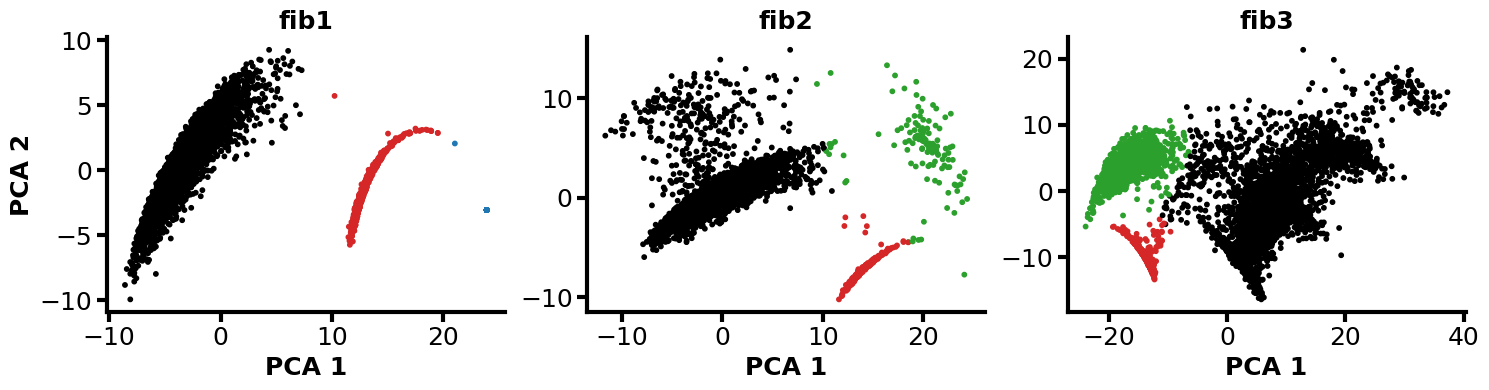

In [27]:
fig, ax = get_axes(L, max_col=L)
for i,sys in enumerate(SYST):
    colors=Mcolors[i]
    labels = macro_cluster_output[sys]
    ax[i].scatter(datasets_predict[i][0][:CHUNK,0], datasets_predict[i][0][:CHUNK,1], c=np.array(colors)[labels[:CHUNK]], s=10)
    ax[i].set_title(f"{sys}", weight='bold',size=LABEL_SIZE)
    ax[i].tick_params(labelsize=LABEL_SIZE,width=3,size=7)
    
    for side in ['bottom','right','top','left']:
        ax[i].spines[side].set_linewidth(3)
    
    if i == 0:
        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
        ax[i].set_ylabel('PCA 2', weight='bold',size=LABEL_SIZE)
        for side in ['right','top']:
            ax[i].spines[side].set_visible(False)          
    else:
        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
        ax[i].tick_params(labelleft=True)
        for side in ['right','top']:
            ax[i].spines[side].set_visible(False)

fig.tight_layout()    
    
if SAVE_PLOT:
    fig.savefig('clusters_pamm_dendrogram.png')

In [28]:
SYS1rates = np.loadtxt("./fib1_macro_rates.dat")
SYS2rates = np.loadtxt("./fib2_macro_rates.dat")
SYS3rates = np.loadtxt("./fib3_macro_rates.dat")
RATES = {
    'fib1' : SYS1rates,
    'fib2' : SYS2rates,
    'fib3' : SYS3rates
}

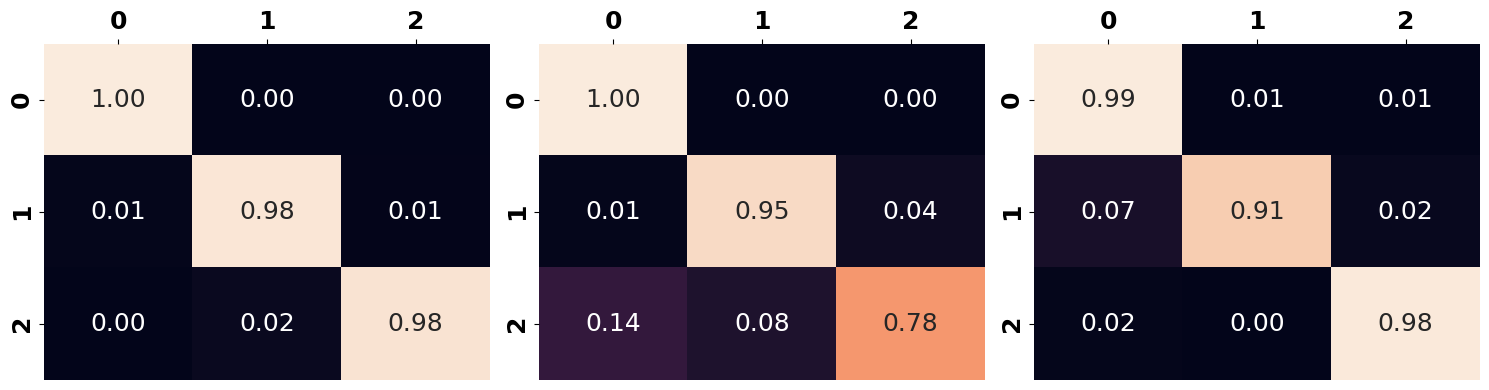

In [29]:
fig, ax = get_axes(L, max_col=3, fig_frame=(5,4), res=100)
for i,sys in enumerate(RATES):
    PLTmatrixrates(ax[i], RATES[sys])

fig.tight_layout()    
    
if SAVE_PLOT:
    fig.savefig('macro_clusters_pamm_matrix.png')